In [2]:
pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.7/655.7 kB 3.7 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=69a02c5b3d1eb1f4f2311e18ff507e4252219b9f079a722d6177b0652f4b46bf
  Stored in directory: /Users/harshithgudapati/Library/Caches/pip/wheels/5f/d4/d7/4189b07b5902ee9f3ce0dbb14909fbe8037c39d6c63ffd49c9
Successfully built htmlmin
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport


In [29]:
data = pd.read_csv('red_wine.csv')
df = pd.DataFrame(data, columns=["citric acid", "sulphates", "alcohol", "type"])

In [31]:
profile = ProfileReport(df, title="Profiling Report", explorative = True)

In [33]:
profile.to_file("RED_WINE_report2.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 191.55it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
import joblib

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [37]:
# Load dataset
red_wine = pd.read_csv("red_wine.csv")

In [39]:
# Encode target variable (assuming 'low' → 0, 'high' → 1)
label_encoder = LabelEncoder()
red_wine["type"] = label_encoder.fit_transform(red_wine["type"])

# Split features and target variable
X_red = red_wine.drop(columns=["type"])
y_red = red_wine["type"]


In [41]:
print(y_red)

0      1
1      1
2      0
3      1
4      1
      ..
566    1
567    0
568    0
569    1
570    0
Name: type, Length: 571, dtype: int64


In [43]:
# Define 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [81]:
# ---- Baseline Model (Dummy Classifier) ----
dummy_clf = DummyClassifier(strategy="most_frequent")
y_pred_dummy = cross_val_predict(dummy_clf, X_red, y_red, cv=cv, method="predict")
y_proba_dummy = cross_val_predict(dummy_clf, X_red, y_red, cv=cv, method="predict_proba")[:, 1]

# Compute baseline metrics
baseline_accuracy = accuracy_score(y_red, y_pred_dummy)
baseline_auc = roc_auc_score(y_red, y_proba_dummy)

# Store baseline results
results2 = {"Model": ["Baseline"], "AUC": [baseline_auc], "Accuracy": [baseline_accuracy]}


In [83]:
 #---- Define Models ----
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM-Linear": SVC(kernel="linear", probability=True, random_state=42),
    "SVM-RBF": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# ---- Train Models, Evaluate with 10-Fold CV, and Save Weights ----
for model_name, model in models.items():
    # Train the model on full red wine dataset
    model.fit(X_red, y_red)
    
    # Save trained model weights
    joblib.dump(model, f"{model_name}1.pkl")

    # Evaluate using 10-fold CV
    y_pred = cross_val_predict(model, X_red, y_red, cv=cv, method="predict")
    y_proba = cross_val_predict(model, X_red, y_red, cv=cv, method="predict_proba")[:, 1]

    # Compute metrics
    acc = accuracy_score(y_red, y_pred)
    auc = roc_auc_score(y_red, y_proba)

    # Store results
    results2["Model"].append(model_name)
    results2["AUC"].append(auc)
    results2["Accuracy"].append(acc)

 # Store Random Forest probabilities for ROC curve
    if model_name == "Random Forest":
        random_forest_probs = y_proba



In [85]:
# Convert to DataFrame and display results
results_df_3 = pd.DataFrame(results2)
print(results_df_3)

                 Model       AUC  Accuracy
0             Baseline  0.500000  0.528897
1  Logistic Regression  0.873938  0.784588
2          Naive Bayes  0.890495  0.824869
3        Decision Tree  0.797416  0.798599
4           SVM-Linear  0.872677  0.793345
5              SVM-RBF  0.852981  0.535902
6        Random Forest  0.920764  0.840630


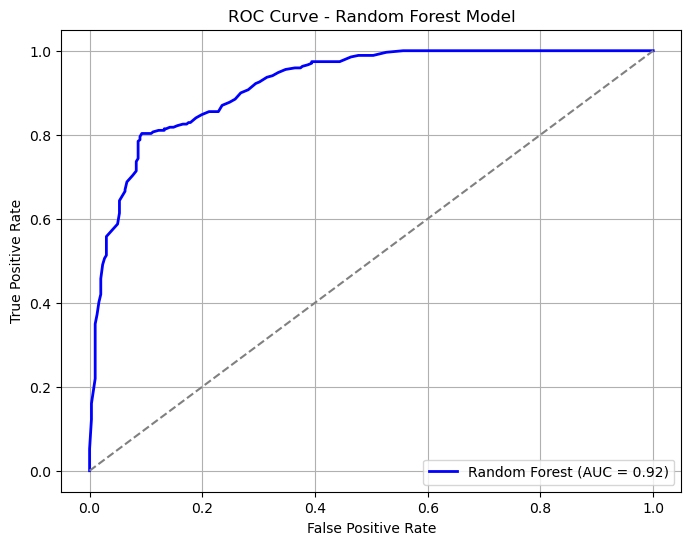

In [99]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
# ---- Generate and Plot ROC Curve for Random Forest ----
if random_forest_probs is not None:
    fpr, tpr, _ = roc_curve(y_red, random_forest_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"Random Forest (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line (random model)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest Model")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [112]:
# testing the pretrained random forest model on the white_wine.csv 

# Load best model 
best_model = joblib.load("Random Forest1.pkl")

# Load and preprocess white_wine.csv
white_wine = pd.read_csv("white_wine.csv")
white_wine["type"] = label_encoder.transform(white_wine["type"])
X_white = white_wine.drop(columns=["type"])
y_white = white_wine["type"]

# Make predictions on white wine dataset

y_proba_white = best_model.predict_proba(X_white)[:, 1]

auc_white = roc_auc_score(y_white, y_proba_white)

print(f"AUC on white wine dataset: {auc_white}")


AUC on white wine dataset: 0.9739633558341368


In [116]:
#Testing the pretrained naive bayes model on the white wine dataset.
best_model1 = joblib.load("Naive Bayes1.pkl")

# Load and preprocess white_wine.csv
white_wine = pd.read_csv("white_wine.csv")
white_wine["type"] = label_encoder.transform(white_wine["type"])
X_white = white_wine.drop(columns=["type"])
y_white = white_wine["type"]

# Make predictions on white wine dataset

y_proba_white = best_model1.predict_proba(X_white)[:, 1]

auc_white = roc_auc_score(y_white, y_proba_white)

print(f"AUC on white wine dataset: {auc_white}")

AUC on white wine dataset: 0.9488910318225652
